# O conjunto de dados
Neste tutorial, usaremos dados habitacionais da Califórnia do Kaggle (aqui). Usaremos dados de localização (latitude e longitude), bem como o valor mediano da casa. Agruparemos as casas por localização e observaremos como os preços das casas flutuam na Califórnia. Salvamos o conjunto de dados como um arquivo csv chamado ‘housing.csv’ em nosso diretório de trabalho e o lemos usando pandas.

In [1]:
import pandas as pd

home_data = pd.read_csv('housing.csv', usecols = ['longitude', 'latitude', 'median_house_value'])
home_data.head()

,longitude,latitude,median_house_value
0,-122.23,37.88,452600.0
1,-122.22,37.86,358500.0
2,-122.24,37.85,352100.0
3,-122.25,37.85,341300.0
4,-122.25,37.85,342200.0


Os dados incluem 3 variáveis que selecionamos usando o parâmetro usecols:

longitude: um valor que representa a distância a oeste de uma casa. Valores mais elevados representam casas mais a oeste.
latitude: um valor que representa a distância ao norte de uma casa. Valores mais altos representam casas mais ao norte.
median_house_value: o preço médio da casa dentro de um bloco medido em dólares americanos.

# Fluxo de trabalho de agrupamento k-Means

Como outros algoritmos de aprendizado de máquina, o k-Means Clustering tem um fluxo de trabalho.

Neste tutorial, vamos nos concentrar na coleta e divisão dos dados (na preparação de dados) e no ajuste de hiperparâmetros, no treinamento do seu modelo e na avaliação do desempenho do modelo (na modelagem). Grande parte do trabalho envolvido em algoritmos de aprendizado não supervisionado reside no ajuste de hiperparâmetros e na avaliação de desempenho para obter os melhores resultados de seu modelo.

# Visualize os dados

Começamos visualizando nossos dados habitacionais. Analisamos os dados de localização com um mapa de calor baseado no preço médio de um bloco. Usaremos o Seaborn para criar gráficos rapidamente neste tutorial (consulte nosso curso Introdução à visualização de dados com Seaborn para entender melhor como esses gráficos estão sendo criados).

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

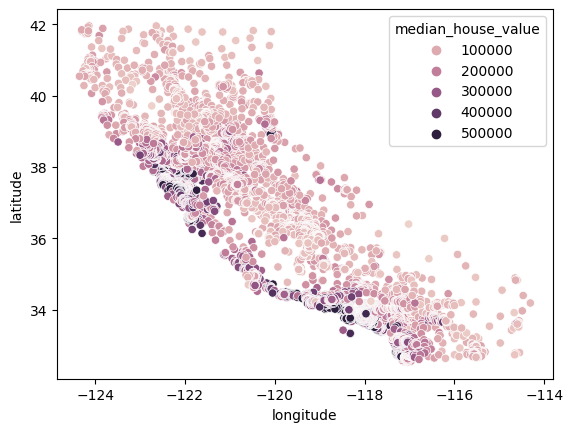

In [2]:
import seaborn as sns

sns.scatterplot(data = home_data, x = 'longitude', y = 'latitude', hue = 'median_house_value')

Vemos que a maioria das casas caras está na costa oeste da Califórnia, com diferentes áreas que possuem grupos de casas com preços moderados. Isto é esperado, uma vez que normalmente as propriedades à beira-mar valem mais do que as casas que não estão na costa.

Os clusters costumam ser fáceis de detectar quando você usa apenas 2 ou 3 recursos.

# Normalizando os dados

Ao trabalhar com algoritmos baseados em distância, como k-Means Clustering, devemos normalizar os dados. Se não normalizarmos os dados, variáveis com escalas diferentes terão pesos diferentes na fórmula de distância que está sendo otimizada durante o treinamento. Por exemplo, se incluíssemos o preço no cluster, além da latitude e longitude, o preço teria um impacto descomunal nas otimizações porque sua escala é significativamente maior e mais ampla do que as variáveis de localização limitadas.

Primeiro configuramos divisões de treinamento e teste usando train_test_split do sklearn.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(home_data[['latitude', 'longitude']], home_data[[
                                                    'median_house_value']], test_size=0.33, random_state=0)

A seguir, normalizamos os dados de treinamento e teste usando o método preprocessing.normalize() do sklearn.

In [4]:
from sklearn import preprocessing

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

# Ajustando e avaliando o modelo

Para a primeira iteração, escolheremos arbitrariamente um número de clusters (referidos como k) de 3. Construir e ajustar modelos no sklearn é muito simples. Criaremos uma instância de KMeans, definiremos o número de clusters usando o atributo n_clusters, definiremos n_init, que define o número de iterações que o algoritmo executará com diferentes sementes de centróide, para “auto”, e definiremos random_state como 0, então obtemos o mesmo resultado cada vez que executamos o código. Podemos então ajustar o modelo aos dados de treinamento normalizados usando o método fit().

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state = 0, n_init=10)
kmeans.fit(X_train_norm)

KMeans(n_clusters=3, random_state=0)

Assim que os dados estiverem ajustados, podemos acessar os rótulos do atributo (labels_attribute). Abaixo, visualizamos os dados que acabamos de ajustar.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

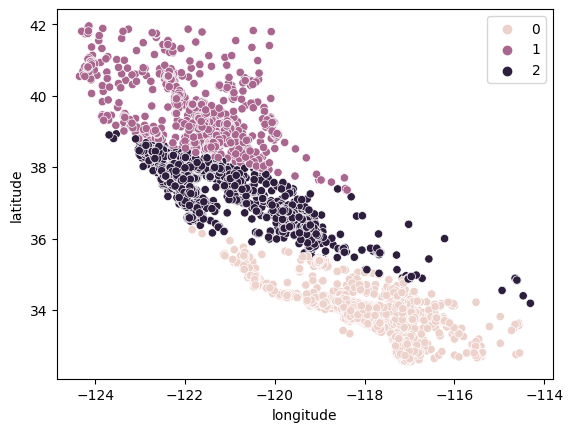

In [8]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = kmeans.labels_)

Vemos que os dados estão agora claramente divididos em 3 grupos distintos (Norte da Califórnia, Centro da Califórnia e Sul da Califórnia). Também podemos observar a distribuição dos preços médios das casas nestes 3 grupos usando um boxplot.

<AxesSubplot:ylabel='median_house_value'>

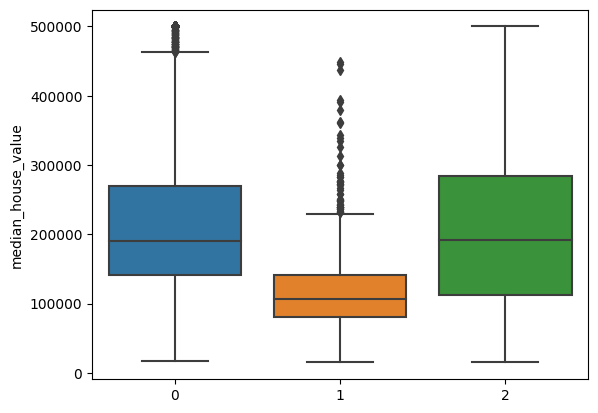

In [9]:
sns.boxplot(x = kmeans.labels_, y = y_train['median_house_value'])

Vemos claramente que os clusters do Norte e do Sul têm distribuições semelhantes de valores medianos das casas (clusters 0 e 2) que são superiores aos preços no cluster central (cluster 1).

Podemos avaliar o desempenho do algoritmo de cluster usando uma pontuação Silhouette que faz parte do sklearn.metrics, onde uma pontuação mais baixa representa um melhor ajuste.

In [10]:
from sklearn.metrics import silhouette_score

silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean')

0.7499371920703546

Como não observamos a força de diferentes números de clusters, não sabemos quão bom é o ajuste do modelo k = 3. Na próxima seção, exploraremos diferentes clusters e compararemos o desempenho para tomar uma decisão sobre os melhores valores de hiperparâmetros para nosso modelo.

# Escolhendo o melhor número de clusters

O ponto fraco do clustering k-means é que não sabemos de quantos clusters precisamos apenas executando o modelo. Precisamos testar intervalos de valores e tomar uma decisão sobre o melhor valor de k. Normalmente tomamos uma decisão usando o método Elbow para determinar o número ideal de clusters onde não estamos ajustando demais os dados com muitos clusters e também não ajustando mal com poucos.

Criamos o loop abaixo para testar e armazenar diferentes resultados de modelos para que possamos tomar uma decisão sobre o melhor número de clusters.

In [12]:
K = range(2, 8)
fits = []
score = []

for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init=10).fit(X_train_norm)
    
    # append the model to fits
    fits.append(model)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(X_train_norm, model.labels_, metric='euclidean'))

Podemos então primeiro observar visualmente alguns valores diferentes de k.

Primeiro olhamos para k = 2.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

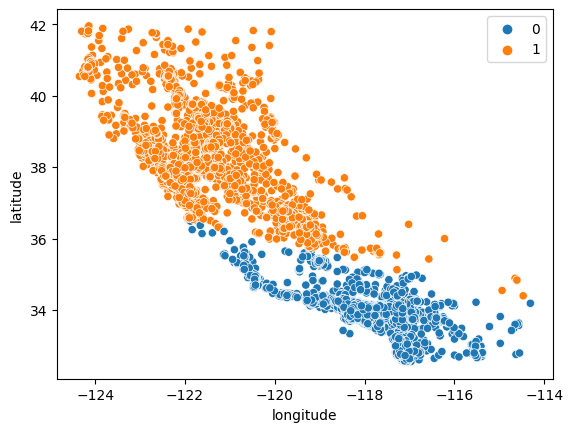

In [13]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[0].labels_)

O modelo faz um bom trabalho ao dividir o estado em duas metades, mas provavelmente não captura nuances suficientes no mercado imobiliário da Califórnia. A seguir, olhamos para k = 4.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

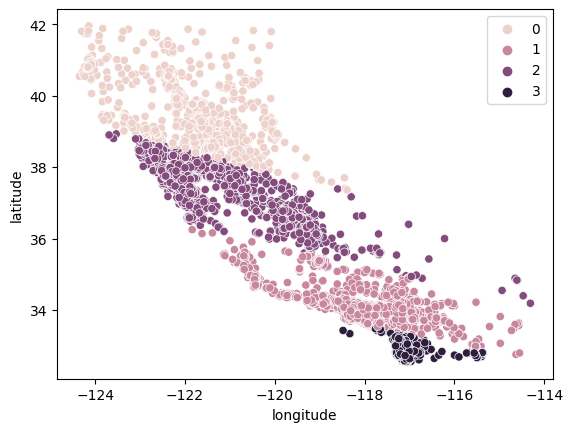

In [14]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[2].labels_)

Vemos este gráfico agrupar a Califórnia em grupos mais lógicos em todo o estado, com base na distância ao norte ou ao sul das casas no estado. Este modelo provavelmente captura mais nuances no mercado imobiliário à medida que avançamos pelo estado.

Finalmente, olhamos para k = 7.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

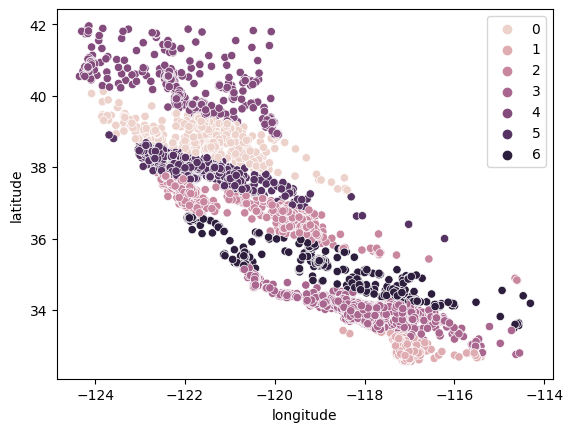

In [16]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[5].labels_)

O gráfico acima parece ter muitos clusters. Sacrificamos a fácil interpretação dos clusters para um resultado de geo-clustering “mais preciso”.

Normalmente, à medida que aumentamos o valor de K, vemos melhorias nos clusters e no que eles representam até certo ponto. Começamos então a ver retornos decrescentes ou um desempenho ainda pior. Podemos ver isso visualmente para ajudar a tomar uma decisão sobre o valor de k usando um gráfico de cotovelo onde o eixo y é uma medida da qualidade do ajuste e o eixo x é o valor de k.

<AxesSubplot:>

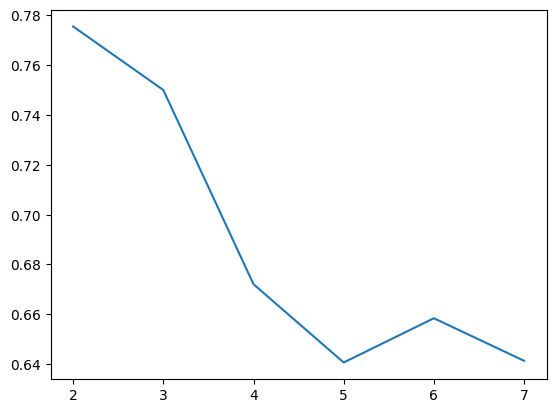

In [17]:
sns.lineplot(x = K, y = score)

Normalmente escolhemos o ponto onde as melhorias no desempenho começam a diminuir ou piorar. Vemos que k = 5 é provavelmente o melhor que podemos fazer sem overfitting.

Também podemos ver que os clusters fazem um trabalho relativamente bom ao dividir a Califórnia em clusters distintos e esses clusters mapeiam relativamente bem para diferentes faixas de preços, como visto abaixo.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

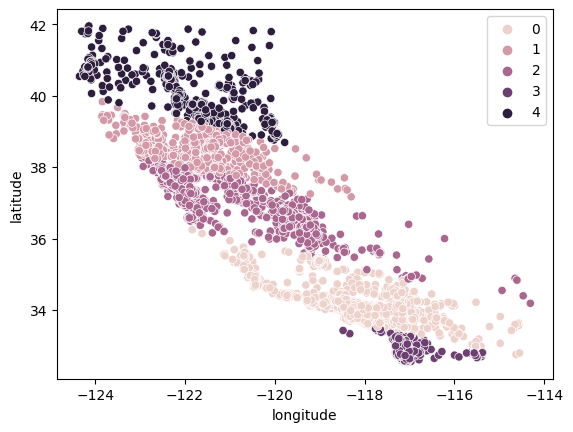

In [18]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[3].labels_)

<AxesSubplot:ylabel='median_house_value'>

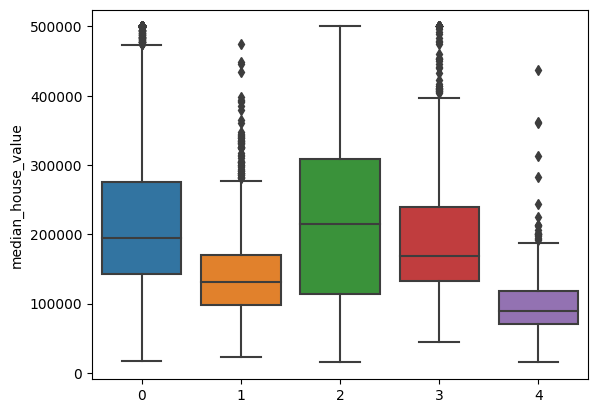

In [19]:
sns.boxplot(x = fits[3].labels_, y = y_train['median_house_value'])